Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 8.  Winter 2026.

Here we will demonstrate different methods of validation- splitting your data into training and testing blocks so that you can estimate the testing error.  This is useful for directly estimating the error and also for selecting hyperparameters, such as the degree of polynomial regression or a $\lambda$ parameter in regularization.  

We'll demonstrate these methods as we build a model to predict the power output from a combined cycle power plant.  A combined cycle power plant generates combustion gases from coal, which are then burned in a gas turbine to produce power.  The waste heat from the gas turbine is used to create steam, which is then fed to a steam turbine to generate additional power- hence "combined cycle."  We'll build a model to predict how ambinet conditions affect the power output of the plant.  Our target is electrical power output (PE) in MW, and our features are ambient temperature in Celcius (AT), ambient pressure in millibar (AP), relative humidity in % (RH), and exhaust vacuum in cm Hg (V).  

This is a real world data set taken from the University of California, Irvine Machine Learning Repository:
https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant

Let's load our libraries and data set.  Our features ($\mathbf{X}$) will be ambient temperature (AT), ambient pressure (AP), relative humidity (RH), and exhaust vacuum (V).  Our target $y$ will be the electric power output (PE).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd

In [ ]:
#read data
df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture8/combined_cycle_power_plant.csv')

#set features
X = df[['AT', 'AP', 'RH', 'V']].values

#set target
y = df['PE'].values

As always, let's get a sense of what we're dealing with.

Number of data points:  9568


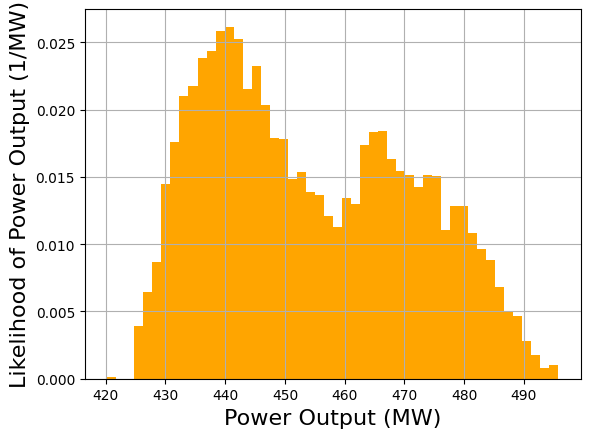

In [ ]:
print('Number of data points: ', y.size)

fig,ax = plt.subplots()
ax.hist(y, bins=50, density=True, color='orange')
ax.set_xlabel('Power Output (MW)',fontsize=16)
ax.set_ylabel('Likelihood of Power Output (1/MW)',fontsize=16)
ax.grid()
plt.show()

# Validation

With validation, we shuffle our data and then split it into a training set and a testing set.  <code>sklearn</code> has a very convenient function called <code>train_test_split</code> that does this automatically.  The <code>test_size</code> keyword determines the fraction of the data that will be put in the test set.  Here we chose 50%.

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)
print('Number of training data points: ', y_train.size)
print('Number of testing data points: ', y_test.size)

Number of training data points:  4784
Number of testing data points:  4784


Now that we have training and testing sets, we'll standardize the data and fit it to a model.  As an example, we'll just do some linear regression.

In [ ]:
#standardize features
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#fit model
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Now we can get the training error and test errors from the fitted model.

In [ ]:
training_mse = sklearn.metrics.mean_squared_error(y_train, model.predict(X_train))
test_mse = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test))

print('Training MSE: ', np.round(training_mse, decimals = 2), ' MW^2')
print('Test MSE: ', np.round(test_mse, decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(training_mse), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(test_mse), decimals=2), ' MW')

Training MSE:  21.56  MW^2
Test MSE:  20.0  MW^2
Training RMSE:  4.64  MW
Test RMSE:  4.47  MW


Let's redo with only 20% of the data in the test set as another example.

In [ ]:
#train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
print('Number of training data points: ', y_train.size)
print('Number of testing data points: ', y_test.size)

#standardize features
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#fit model
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

training_mse = sklearn.metrics.mean_squared_error(y_train, model.predict(X_train))
test_mse = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test))

print('Training MSE: ', np.round(training_mse, decimals = 2), ' MW^2')
print('Test MSE: ', np.round(test_mse, decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(training_mse), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(test_mse), decimals=2), ' MW')

Number of training data points:  7654
Number of testing data points:  1914
Training MSE:  20.68  MW^2
Test MSE:  21.11  MW^2
Training RMSE:  4.55  MW
Test RMSE:  4.59  MW


Because we split the data randomly and only fit the model once, there is some variability in our training and test error.  Leave-One-Out Cross Validation (LOOCV) fixes this, by using the first data point as the test set, fitting the model to the other n-1 points, and then repeating that procedure for every data point.

# Leave-One-Out Cross Validation (LOOCV)

With Leave-One-Out Cross Validation, we can make use of <code>sklearn</code>'s <code>LeaveOneOut</code> function.  It will sequentially leave a single data point out of the training set, training the model, and use the left out data point for estimating test error.

In [ ]:
loocv = sklearn.model_selection.LeaveOneOut()
model = sklearn.linear_model.LinearRegression()

#create an empty array to store the error from each iteration
training_errors = []
test_errors = []

#loop over the data set, holding out each data point sequentially
for train_idx, test_idx in loocv.split(X):

  #split the data into training and test
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  #standardize the data
  scaler = sklearn.preprocessing.StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #train the current model
  model.fit(X_train_scaled, y_train)

  #make predictions on the test error and record them in the arrays
  y_pred = model.predict(X_test_scaled)
  test_mse = sklearn.metrics.mean_squared_error([y_test], [y_pred])  # MSE for this test sample
  test_errors.append(test_mse)

  #make predictions on the training error and record them in the arrays
  y_pred = model.predict(X_train_scaled)
  training_mse = sklearn.metrics.mean_squared_error([y_train], [y_pred])  # MSE for this test sample
  training_errors.append(training_mse)

#print the training and test MSE
print('Training MSE: ', np.round(np.mean(training_errors), decimals = 2), ' MW^2')
print('Test MSE: ', np.round(np.mean(test_errors), decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(np.mean(training_errors)), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(np.mean(test_errors)), decimals=2), ' MW')



Training MSE:  20.77  MW^2
Test MSE:  20.79  MW^2
Training RMSE:  4.56  MW
Test RMSE:  4.56  MW


Using the <code>make_pipeline</code> and <code>cross_validate</code> functionality, we can make this code compact.

In [ ]:
#set up the scaler, model, and LOOCV
scaler = sklearn.preprocessing.StandardScaler()
loocv = sklearn.model_selection.LeaveOneOut()
model = sklearn.linear_model.LinearRegression()

#create a pipeline with the scaler and model
pipeline = sklearn.pipeline.make_pipeline(scaler, model)

#this will apply the cross validation automatically and put the results in 'cv_results'
#the scoring is the negative of the mean squared error
cv_results = sklearn.model_selection.cross_validate(pipeline, X, y, cv=loocv, scoring='neg_mean_squared_error', return_train_score=True)

#collect the errors from the validation
#since the scores are the negative of MSE, we multiply by -1 to get the MSE
training_errors = -1.0*cv_results['train_score']
test_errors = -1.0*cv_results['test_score']

#print the training and test MSE
print('Training MSE: ', np.round(np.mean(training_errors), decimals = 2), ' MW^2')
print('Test MSE: ', np.round(np.mean(test_errors), decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(np.mean(training_errors)), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(np.mean(test_errors)), decimals=2), ' MW')



Training MSE:  20.77  MW^2
Test MSE:  20.79  MW^2
Training RMSE:  4.56  MW
Test RMSE:  4.56  MW


LOOCV gives us very error good estimates and they are always consistent.  But as we can see, it can be computationally expensive.  Even with simple linear regression, fitting the model ~9000 different times takes a while, about 2 minutes in this case.  A good intermediate solution is $k$-fold cross validation, where we break the data into $k=$5-10 chunks, using each chunk as a test set and the remainder as training.  In that case we'll only need to fit the model $k$ times.

# $k$-Fold Cross Validation

Here we'll set up a 5-fold cross validation on our power plant data and then do 5 linear regressions with each split to estimate the error.

In [ ]:
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
model = sklearn.linear_model.LinearRegression()

#create an empty array to store the error from each iteration
training_errors = []
test_errors = []

#loop over the data set, holding out each data point sequentially
for train_idx, test_idx in kf.split(X):

  #split the data into training and test
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  #standardize the data
  scaler = sklearn.preprocessing.StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #train the current model
  model.fit(X_train_scaled, y_train)

  #make predictions on the test error and record them in the arrays
  y_pred = model.predict(X_test_scaled)
  test_mse = sklearn.metrics.mean_squared_error([y_test], [y_pred])  # MSE for this test sample
  test_errors.append(test_mse)

  #make predictions on the training error and record them in the arrays
  y_pred = model.predict(X_train_scaled)
  training_mse = sklearn.metrics.mean_squared_error([y_train], [y_pred])  # MSE for this test sample
  training_errors.append(training_mse)

#print the training and test MSE
print('Training MSE: ', np.round(np.mean(training_errors), decimals = 2), ' MW^2')
print('Test MSE: ', np.round(np.mean(test_errors), decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(np.mean(training_errors)), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(np.mean(test_errors)), decimals=2), ' MW')



Training MSE:  20.77  MW^2
Test MSE:  20.78  MW^2
Training RMSE:  4.56  MW
Test RMSE:  4.56  MW


These values are fairly consistent and the computational cost is reasonable.  We can also re-write the above code more compactly with <code>make_pipeline</code> and <code>cross_validate</code>.

In [ ]:
#set up the scaler, model, and k-fold cross validation
scaler = sklearn.preprocessing.StandardScaler()
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
model = sklearn.linear_model.LinearRegression()

#create a pipeline with the scaler and model
pipeline = sklearn.pipeline.make_pipeline(scaler, model)

#this will apply the cross validation automatically and put the results in 'cv_results'
#the scoring is the negative of the mean squared error
cv_results = sklearn.model_selection.cross_validate(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

#collect the errors from the validation
#since the scores are the negative of MSE, we multiply by -1 to get the MSE
training_errors = -1.0*cv_results['train_score']
test_errors = -1.0*cv_results['test_score']

#print the training and test MSE
print('Training MSE: ', np.round(np.mean(training_errors), decimals = 2), ' MW^2')
print('Test MSE: ', np.round(np.mean(test_errors), decimals=2), ' MW^2')

print('Training RMSE: ', np.round(np.sqrt(np.mean(training_errors)), decimals=2), ' MW')
print('Test RMSE: ', np.round(np.sqrt(np.mean(test_errors)), decimals=2), ' MW')



Training MSE:  20.76  MW^2
Test MSE:  20.8  MW^2
Training RMSE:  4.56  MW
Test RMSE:  4.56  MW


Finally, let's demonstrate how we can use k-fold cross validation to choose the best hyperparameter using a single data set.  We'll use use multiple polynomial regression to find the best polynomial order for our model.  We'll use 10-fold cross validation.

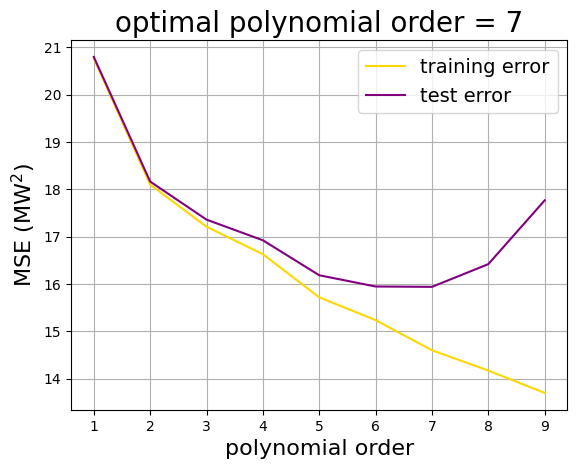

In [ ]:
#set up a range of polynomial orders to test
orders = np.arange(1,10)

#set up arrays to store training and test error
all_training_errors = []
all_test_errors = []

for ord in orders:
  #set up the scaler, model, polynomial features, and k-fold cross validation
  kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
  scaler = sklearn.preprocessing.StandardScaler()
  poly = sklearn.preprocessing.PolynomialFeatures(degree=ord, include_bias=False)
  model = sklearn.linear_model.LinearRegression()

  #create a pipeline with the scaler and model
  pipeline = sklearn.pipeline.make_pipeline(poly, scaler, model)

  #this will apply the cross validation automatically and put the results in 'cv_results'
  #the scoring is the negative of the mean squared error
  cv_results = sklearn.model_selection.cross_validate(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

  #collect the errors from the validation
  #since the scores are the negative of MSE, we multiply by -1 to get the MSE
  training_errors = -1.0*cv_results['train_score']
  test_errors = -1.0*cv_results['test_score']

  #store the training and test errors
  all_training_errors.append(np.mean(training_errors))
  all_test_errors.append(np.mean(test_errors))

#get the optimal lambda value
opt_ord = orders[np.argmin(all_test_errors)]

#plot the training and test error vs. lambda
fig,ax = plt.subplots()
ax.plot(orders, all_training_errors, label='training error', color='gold')
ax.plot(orders, all_test_errors, label='test error', color='purple')
ax.set_title('optimal polynomial order = '+str(opt_ord), fontsize=20)
ax.set_xlabel('polynomial order',fontsize=16)
ax.set_ylabel('MSE (MW$^{2}$)',fontsize=16)
ax.grid()
ax.legend(fontsize=14)
plt.show()
